# Week-4
Evalution metrics for classification problems. 

# Import modules

In [3]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold

# Load and pre-process Data - Model 

In [167]:
df = pd.read_csv('03_data-Telco-Customer-Churn.csv')

# Standardize column names 
df.columns = df.columns.str.lower().str.replace(' ','_')

# get list of categorical features
features_cat = list(df.dtypes[df.dtypes == 'object'].index)

# standardize categorical features data
for f in features_cat:
    df[f] = df[f].str.lower().str.replace(' ','_')
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)


df.churn = (df.churn == 'yes').astype('int')

In [168]:
# Train-Test-Split = 60-20-20
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [169]:
# Get y variables 
y_train = df_train.churn.values
y_val   = df_val.churn.values
y_test  = df_test.churn.values

# delete target from DF
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [170]:
# Numericals 
list_features_num = ['tenure', 'monthlycharges', 'totalcharges']

# Categoical 
list_features_cat = list(set(df_train_full.columns) - set(list_features_num) - set(['churn','customerid']))

list_features_num, list_features_cat

(['tenure', 'monthlycharges', 'totalcharges'],
 ['onlinesecurity',
  'dependents',
  'paymentmethod',
  'phoneservice',
  'multiplelines',
  'techsupport',
  'gender',
  'seniorcitizen',
  'paperlessbilling',
  'deviceprotection',
  'streamingtv',
  'partner',
  'streamingmovies',
  'internetservice',
  'contract',
  'onlinebackup'])

In [171]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list_features_cat + list_features_num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [172]:
# validation 
val_dict = df_val[list_features_cat + list_features_num].to_dict(orient='records')
X_val = dv.transform(val_dict) 

y_pred = model.predict_proba(X_val)[:,1]

# Accuracy
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

****

# Accuracy and dummy model 
- Evalute the model on different thresholds
- check the accuracy of dummy baselines

In [28]:
len(df_val)

1409

In [31]:
# sum to see no. of correct decisions
(y_val == churn_decision).sum(), len(y_val)

(1132, 1409)

In [30]:
# Accuracy
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

Why use the churn threshold? 
- Change the threshold and test 

In [37]:
# testing different thresholds
thresholds = np.linspace(0, 1, 21)
scores = [] 

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print(f't={t:.2f} s={score:.3f}')

t=0.00 s=0.274
t=0.05 s=0.509
t=0.10 s=0.591
t=0.15 s=0.666
t=0.20 s=0.710
t=0.25 s=0.739
t=0.30 s=0.760
t=0.35 s=0.772
t=0.40 s=0.785
t=0.45 s=0.793
t=0.50 s=0.803
t=0.55 s=0.801
t=0.60 s=0.795
t=0.65 s=0.786
t=0.70 s=0.765
t=0.75 s=0.744
t=0.80 s=0.735
t=0.85 s=0.726
t=0.90 s=0.726
t=0.95 s=0.726
t=1.00 s=0.726


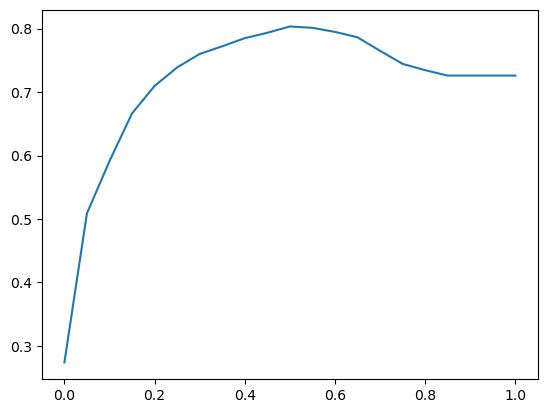

In [38]:
# Plot thresholds and plot s
plt.plot(thresholds, scores)

`Logistic Regression` tries to optimize in such a way that 0.5 is the best thresholds

In [44]:
# Scikit learn function for accuracy 
accuracy_score(y_val, y_pred > 0.5)

0.8034066713981547

- Customers are churning if the score is >1.0. Accuracy for this threshols is `73%`, which is less than `80% threshold=@0.5`.

- Our model = 80%
- Dummy model = 73%
- Why bother? 
    - 7% increase 
    - Accuracy doesn't completely tell everything about churning and non-churning
    - `Class Imbalances` will impact model performance,

***

# Confusion table
- Different tyeps of errors and correct decisions
- Arranign them into a table

In [47]:
# Actuals
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [50]:
# precitions
t = 0.5
pred_positive = (y_pred >= t)
pred_negative = (y_pred < t)

In [78]:
# combine above both - TP, TN
TP = (pred_positive & actual_positive).sum()
TN = (pred_negative & actual_negative).sum()

TP, TN

(210, 922)

In [79]:
# FP, FN 
FP = (pred_positive & actual_negative).sum()
FN = (pred_negative & actual_positive).sum()

FP, FN 

(101, 176)

In [60]:
# numpy confusion matrix
confusion_matrix = np.array([[TN,FN],[FP,TP]])
confusion_matrix

array([[922, 176],
       [101, 210]])

In [61]:
# Confusion matrix
df_confusion = pd.DataFrame(data=confusion_matrix)

df_confusion

,0,1
0,922,176
1,101,210


- We have more FN=176 than FP=101
- FP = we lose money as they use promo and leave 
- FN = we don't send them promo emails. They leave. So, lose customer and profit here!

In [64]:
# normalized confutions mtraix 
df_confusion_norm = df_confusion / df_confusion.sum().sum() * 100

df_confusion_norm

,0,1
0,65.436480,12.491128
1,7.168204,14.904187


In [72]:
# Accuracy vs TP + TN - %
accuracy = 80

TP = 65
TN = 15

accuracy == (TP+TN)

True

***

# Precision and Recall 

precision = Fraction of positive predictions that are correct

In [80]:
Precision = TP / (FP + TP)
Precision

0.6752411575562701

In [81]:
Recall = TP / (FN + TP)
Recall

0.5440414507772021

***

# ROC Curces 

## TPR and FRP 

In [86]:
FPR = FP / (TN + FP)
FPR 

0.09872922776148582

In [87]:
TPR = TP / (TP + FN)
TPR 

0.5440414507772021

In [94]:
thresholds = np.linspace(0, 1, 101)

scores = []


for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)
    
    TP = (pred_positive & actual_positive).sum()
    TN = (pred_negative & actual_negative).sum()

    FP = (pred_positive & actual_negative).sum()
    FN = (pred_negative & actual_positive).sum()

    scores.append((t, TP, FP, FN, TN))

In [97]:
columns = ['threshold', 'TP', 'FP', 'FN', 'TN']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,TP,FP,FN,TN
0,0.00,386,1023,0,0
1,0.01,385,912,1,111
2,0.02,384,830,2,193
3,0.03,383,766,3,257
4,0.04,381,715,5,308
...,...,...,...,...,...
96,0.96,0,0,386,1023
97,0.97,0,0,386,1023
98,0.98,0,0,386,1023
99,0.99,0,0,386,1023


In [98]:
df_scores['TPR'] =  df_scores.TP / (df_scores.TP + df_scores.FN)
df_scores['FPR'] =  df_scores.FP / (df_scores.FP + df_scores.TN)

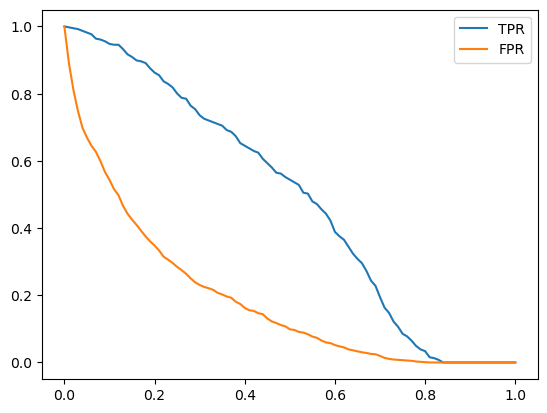

In [103]:
# plotting TPR-FPR 

plt.plot(df_scores.threshold, df_scores['TPR'], label='TPR')
plt.plot(df_scores.threshold, df_scores['FPR'], label='FPR')
plt.legend()

## Random model 

In [104]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [107]:
((y_rand > 0.5) == y_val).mean()

0.5017743080198722

In [108]:
def tpr_fpr_dataframe(y_val, y_pred):

    thresholds = np.linspace(0, 1, 101)

    scores = []


    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        TP = (pred_positive & actual_positive).sum()
        TN = (pred_negative & actual_negative).sum()

        FP = (pred_positive & actual_negative).sum()
        FN = (pred_negative & actual_positive).sum()

        scores.append((t, TP, FP, FN, TN))
        
        
    columns = ['threshold', 'TP', 'FP', 'FN', 'TN']

    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['TPR'] =  df_scores.TP / (df_scores.TP + df_scores.FN)
    df_scores['FPR'] =  df_scores.FP / (df_scores.FP + df_scores.TN)
    
    return df_scores

In [109]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand

,threshold,TP,FP,FN,TN,TPR,FPR
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,382,1013,4,10,0.989637,0.990225
2,0.02,379,993,7,30,0.981865,0.970674
3,0.03,375,979,11,44,0.971503,0.956989
4,0.04,372,969,14,54,0.963731,0.947214
...,...,...,...,...,...,...,...
96,0.96,14,41,372,982,0.036269,0.040078
97,0.97,11,36,375,987,0.028497,0.035191
98,0.98,8,19,378,1004,0.020725,0.018573
99,0.99,6,7,380,1016,0.015544,0.006843


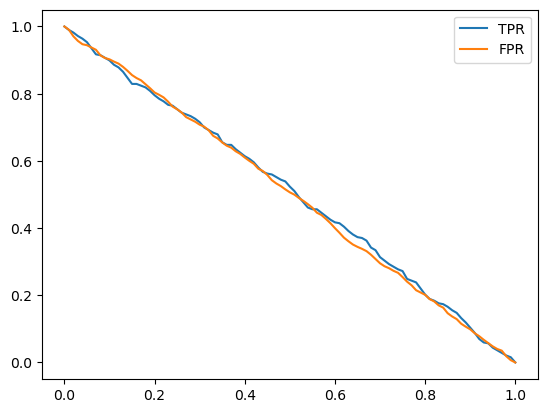

In [110]:
# plotting TPR-FPR 

plt.plot(df_rand.threshold, df_rand['TPR'], label='TPR')
plt.plot(df_rand.threshold, df_rand['FPR'], label='FPR')
plt.legend()

## Ideal model 

In [111]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1023, 386)

In [112]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [114]:
y_ideal_pred = np.linspace(0,1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [117]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [118]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal

,threshold,TP,FP,FN,TN,TPR,FPR
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,386,1008,0,15,1.000000,0.985337
2,0.02,386,994,0,29,1.000000,0.971652
3,0.03,386,980,0,43,1.000000,0.957967
4,0.04,386,966,0,57,1.000000,0.944282
...,...,...,...,...,...,...,...
96,0.96,57,0,329,1023,0.147668,0.000000
97,0.97,43,0,343,1023,0.111399,0.000000
98,0.98,29,0,357,1023,0.075130,0.000000
99,0.99,15,0,371,1023,0.038860,0.000000


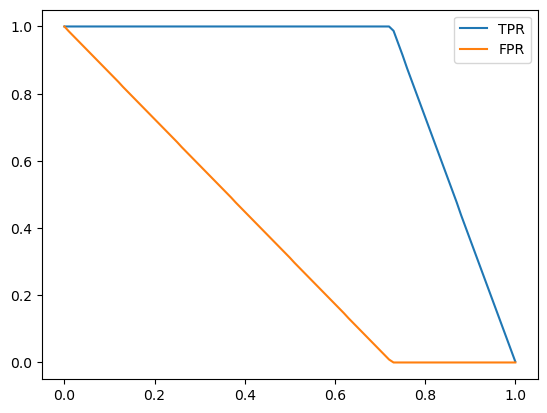

In [119]:
# plotting TPR-FPR 

plt.plot(df_ideal.threshold, df_ideal['TPR'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['FPR'], label='FPR')
plt.legend()

## Plotting all together

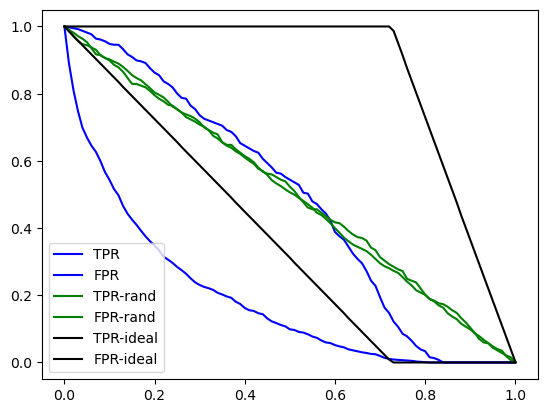

In [123]:
# plotting TPR-FPR 

plt.plot(df_scores.threshold, df_scores['TPR'], label='TPR',color='blue')
plt.plot(df_scores.threshold, df_scores['FPR'], label='FPR',color='blue')

plt.plot(df_rand.threshold, df_rand['TPR'], label='TPR-rand',color='green')
plt.plot(df_rand.threshold, df_rand['FPR'], label='FPR-rand',color='green')

plt.plot(df_ideal.threshold, df_ideal['TPR'], label='TPR-ideal',color='black')
plt.plot(df_ideal.threshold, df_ideal['FPR'], label='FPR-ideal',color='black')

plt.legend()

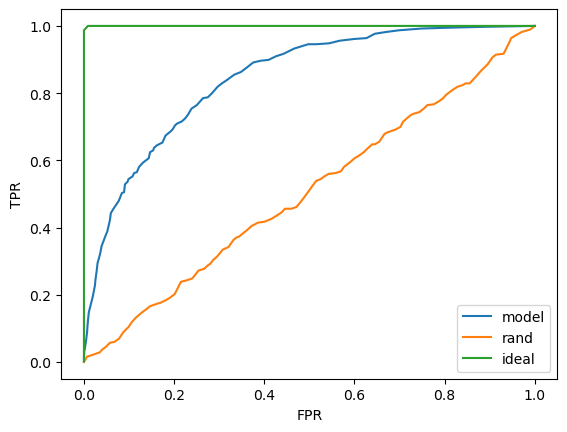

In [126]:
plt.plot(df_scores.FPR, df_scores.TPR, label='model')
plt.plot(df_rand.FPR, df_rand.TPR, label='rand')
plt.plot(df_ideal.FPR, df_ideal.TPR, label='ideal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

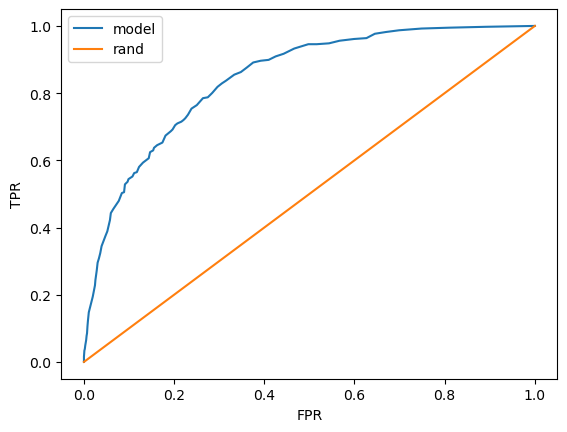

In [128]:
plt.plot(df_scores.FPR, df_scores.TPR, label='model')
plt.plot([0,1], [0,1], label='rand')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## ROC curve using sklearn

In [130]:
fpr, tpr, thr = roc_curve(y_val, y_pred)


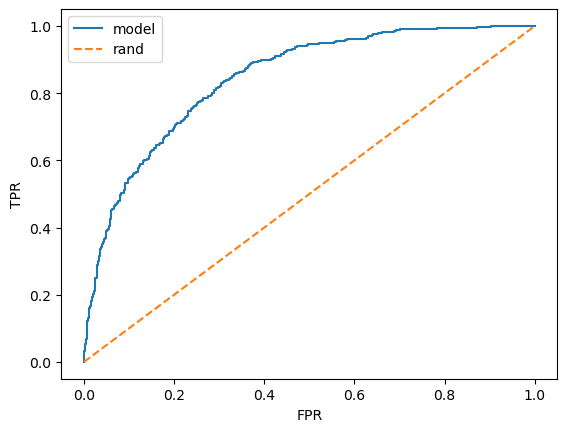

In [131]:
plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='rand', ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# ROC-AUC

In [133]:
# auc = Area under any curve
auc(fpr, tpr)

0.8438454408703446

In [134]:
auc(df_scores.FPR, df_scores.TPR)

0.8438403760148705

In [135]:
auc(df_ideal.FPR, df_ideal.TPR)

0.9999430203759136

In [136]:
roc_auc_score(y_val, y_pred)

0.8438454408703446

# Cross-Validation
- Evaluting same model on different subsets of data 
- Getting the average prediction and the spread within predictions. 

In [183]:
def train(df_train, y_train, C=0.1):
    
    dicts = df_train[list_features_cat + list_features_num].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [184]:
dv, model = train(df_train, y_train, C=10)

In [185]:
def predict(df, dv, model):
    dicts = df[list_features_cat + list_features_num].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [186]:
y_pred = predict(df_val, dv, model)

In [188]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [189]:
!pip install tqdm 

In [190]:
from tqdm.auto import tqdm

In [206]:
nsplits = 5
kfold = KFold(n_splits=nsplits, random_state=1, shuffle=True)

for C in tqdm([0.001, 0.01, 0.1, 1.0, 10.], total=nsplits):

    scores = [] 

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C ={C} score_mean={np.mean(scores)*100:.3f}, score_std={np.std(scores)*100:.3f}')


  0%|          | 0/5 [00:00<?, ?it/s]

C =0.001 score_mean=82.474, score_std=0.904
C =0.01 score_mean=83.984, score_std=0.882
C =0.1 score_mean=84.126, score_std=0.844
C =1.0 score_mean=84.041, score_std=0.854
C =10.0 score_mean=84.117, score_std=0.751


In [208]:
# Train final model 
dv, model = train(df_train_full, df_train_full.churn.values, C=0.1)
y_pred = predict(df_test, dv, model)


# AUC final model
auc = roc_auc_score(y_test, y_pred)

auc

0.8569027809375237

***